# Text-Sentiment-Analysis-using-LSTM

<a href="https://colab.research.google.com/github/LuluW8071/Text-Sentiment-Analysis/blob/main/Text_Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Load the dataset

In [1]:
import pandas as pd
import numpy as np
import random

In [2]:
sentiment_to_int = {
	"positive": 2,
	"neutral": 1,
	"negative": 0
}

int_to_sentiment = {v: k for k, v in sentiment_to_int.items()}

# Reduce to 10000 samples if you want your model to train faster (while loss may increase)
samples = 10000

# Read dataset and take random 20000 samples
df = pd.read_csv("dataset.csv")
df = df.sample(n=samples, random_state=random.randint(0, 100))

# Reset the index
df.reset_index(drop=True, inplace=True)
df.head(), df.shape, df["language"].value_counts()[:5],df["label"].value_counts()

(                                                text language     label
 0  "...because [the] law isnfucked up—it's fuckin...       en  negative
 1  Chris Pratt Confronts Outrage Over Religious B...       en  negative
 2  Best part in the ink from the flames yeah, #Ap...       en  positive
 3  @JackPosobiec This is how bad this show is!  T...       en   neutral
 4  I’m all cozy and ready for the fnaf security b...       en   neutral,
 (10000, 3),
 language
 en    9286
 fr     146
 es     125
 pt     105
 ja      79
 Name: count, dtype: int64,
 label
 neutral     4337
 positive    2836
 negative    2827
 Name: count, dtype: int64)

## 2. Data Analysis

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

train data shape: (8000,)
test data shape: (2000,)


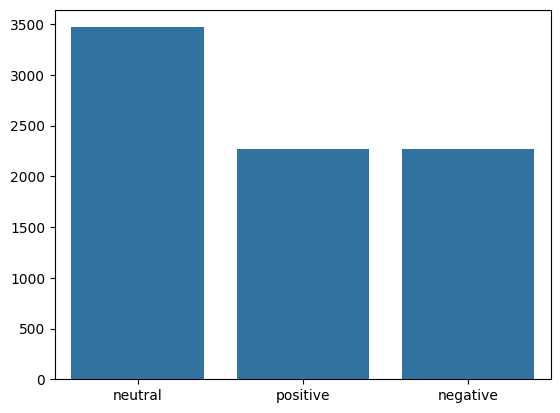

In [4]:
X, y = df['text'].values,df['label'].values
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size = 0.2)
print(f'train data shape: {X_train.shape}')
print(f'test data shape: {X_test.shape}')


val = pd.Series(y_train).value_counts()
sns.barplot(x = np.array(["neutral", "positive", "negative"]),
            y = val.values)
plt.show()

## 3. Text Pre-Processing
- Cleaning up the text data by removing punctuation, extra spaces, and numbers.
- Transform sentences into individual words, remove common words (known as "stop words")
- Keeping track of the 1000 most frequently used words in the dataset
- Assigning tracked words a unique identifier, forming dictionary for one-hot encoding
- Ensuring all sequences have the same length by padding or truncating them as needed by 500 tokens

In [5]:
import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from collections import Counter

from tqdm import tqdm

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mk473\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [6]:
# Precompile regular expressions for faster pre processing [improved by 50% in preprocess]
non_word_chars_pattern = re.compile(r"[^\w\s]")
whitespace_pattern = re.compile(r"\s+")
digits_pattern = re.compile(r"\d")
username_pattern = re.compile(r"@([^\s]+)")
hashtags_pattern = re.compile(r"#\d+")

def preprocess_string(s):
    # Remove all non-word characters (everything except numbers and letters)
    s = non_word_chars_pattern.sub('', s)
    # Replace all runs of whitespaces with single space
    s = whitespace_pattern.sub(' ', s)
    # Replace digits with no space
    s = digits_pattern.sub('', s)
    # Replace usernames with no space
    s = username_pattern.sub('', s)
    # Replace hashtags with no space
    s = hashtags_pattern.sub('', s)
    # Replace specific characters
    s = s.replace("https", "")
    s = s.replace("http", "")
    s = s.replace("rt", "")
    s = s.replace("-", "")
    # Replace <br /> with a space
    s = s.replace("<br />", " ")
    # Replace newline character with empty string
    s = s.replace("\n", "")
    return s

In [7]:
# Create a Tokenize including padding Function
def tokenize(X_train, y_train, X_val, y_val, seq_len):
    word_list = []
    stop_words = set(stopwords.words('english'))

    for sent in tqdm(X_train, desc="Preprocessing train data"):
        words = [preprocess_string(word) for word in sent.lower().split()]
        word_list.extend([word for word in words if word not in stop_words and word != ''])

    corpus = Counter(word_list)
    # Sorting on the basis of most common words
    corpus_ = sorted(corpus, key=corpus.get, reverse=True)[:1000]
    # Creating a dictionary
    onehot_dict = {w: i + 1 for i, w in enumerate(corpus_)}

    # Tokenize and pad sequences
    final_list_train = [[onehot_dict.get(preprocess_string(word), 0) for word in sent.lower().split() if preprocess_string(word) in onehot_dict]
                        for sent in tqdm(X_train, desc="Tokenizing and padding train data")]
    final_list_train = [padded_tokens[-seq_len:] if len(padded_tokens) > seq_len else [0] * (seq_len - len(padded_tokens)) + padded_tokens
                        for padded_tokens in final_list_train]

    final_list_test = [[onehot_dict.get(preprocess_string(word), 0) for word in sent.lower().split() if preprocess_string(word) in onehot_dict]
                       for sent in tqdm(X_val, desc="Tokenizing and padding validation data")]
    final_list_test = [padded_tokens[-seq_len:] if len(padded_tokens) > seq_len
                       else [0] * (seq_len - len(padded_tokens)) + padded_tokens
                       for padded_tokens in final_list_test]

    encoded_train = np.array([sentiment_to_int[label] for label in y_train])
    encoded_test = np.array([sentiment_to_int[label] for label in y_val])

    return np.array(final_list_train), encoded_train, np.array(final_list_test), encoded_test, onehot_dict

In [8]:
seq_len = 300
X_train, y_train, X_test, y_test, vocab = tokenize(X_train,
                                                   y_train,
                                                   X_test,
                                                   y_test,
                                                   seq_len)

len(X_train), len(X_test)

Tokenizing and padding validation data: 100%|██████████| 2000/2000 [00:00<00:00, 17381.68it/s]


(8000, 2000)

In [9]:
X_train, y_train

(array([[  0,   0,   0, ...,   0,   0,  41],
        [  0,   0,   0, ...,  12, 944, 642],
        [  0,   0,   0, ...,   0,   0,  60],
        ...,
        [  0,   0,   0, ...,   3, 324, 334],
        [  0,   0,   0, ...,   0,  21, 750],
        [  0,   0,   0, ..., 618,  39, 104]]),
 array([2, 2, 0, ..., 2, 1, 1]))

## 4. Preparing the data using DataLoader

In [10]:
import torch
from torch.utils.data import TensorDataset, DataLoader

In [11]:
# Create Tensor datasets
train_data = TensorDataset(torch.from_numpy(X_train),
                           torch.from_numpy(y_train))
valid_data = TensorDataset(torch.from_numpy(X_test),
                           torch.from_numpy(y_test))

BATCH_SIZE = 200

# Create train and valid dataloader
train_dataloader = DataLoader(train_data,
                              shuffle=True,
                              batch_size=BATCH_SIZE)
valid_dataloader = DataLoader(valid_data,
                              shuffle=True,
                              batch_size=BATCH_SIZE)

len(train_dataloader), len(valid_dataloader)

(40, 10)

In [12]:
# Sampling one bacth from train_dataloader
sample_data = iter(train_dataloader)
sample_x, sample_y = next(sample_data)

print('Sample input size:', sample_x.size())     # batch_size, seq_length
print('Sample input:', sample_x)
print('Sample output:', sample_y)

Sample input size: torch.Size([200, 300])
Sample input: tensor([[  0,   0,   0,  ...,  54, 506,  12],
        [  0,   0,   0,  ...,   0, 768,  93],
        [  0,   0,   0,  ...,  11, 426,  30],
        ...,
        [  0,   0,   0,  ...,  72, 200, 104],
        [  0,   0,   0,  ...,  42,  93, 432],
        [  0,   0,   0,  ...,   0,   0,   0]], dtype=torch.int32)
Sample output: tensor([2, 2, 1, 0, 0, 2, 2, 0, 1, 0, 2, 2, 0, 2, 0, 1, 1, 0, 1, 2, 0, 2, 0, 0,
        1, 1, 1, 2, 0, 1, 1, 1, 0, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 0,
        0, 0, 1, 2, 2, 2, 1, 0, 1, 0, 0, 1, 0, 2, 0, 1, 2, 2, 2, 0, 1, 1, 2, 1,
        2, 1, 2, 1, 1, 0, 0, 0, 2, 1, 2, 2, 2, 2, 2, 1, 1, 0, 1, 0, 0, 0, 1, 2,
        1, 2, 0, 1, 2, 1, 0, 0, 2, 2, 2, 0, 2, 2, 1, 2, 2, 2, 0, 1, 1, 0, 1, 2,
        1, 1, 2, 0, 1, 0, 1, 0, 1, 0, 1, 2, 1, 1, 2, 1, 2, 2, 2, 1, 2, 2, 1, 0,
        1, 2, 1, 2, 2, 1, 0, 1, 0, 0, 1, 1, 1, 2, 0, 1, 0, 2, 1, 1, 0, 2, 1, 1,
        1, 2, 0, 0, 1, 0, 2, 0, 2, 0, 1, 2, 2, 1, 0, 0, 1, 0

## 5. Building a LSTM Model

<img src = "assets/LSTM-Model.png">

In [13]:
import torch
from torch import nn
from torch.nn.utils import clip_grad_norm_

# Setting device agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


Here's a breakdown of how each component of the `SentimentLSTM` class processes the tokenized and padded array of text:

### Embedding Layer
The embedding layer (`self.embedding`) takes the tokenized and padded array of text as input. It converts each token (represented as an integer) into a dense vector of fixed size (`embedding_dim`). This dense representation captures semantic similarities between words. The input shape to the embedding layer is `(batch_size, sequence_length)`, where `batch_size` is the number of sequences in the batch and `sequence_length` is the length of each sequence.

### LSTM Layer
The LSTM layer (`self.lstm`) processes the embedded sequences over time. It takes the embedded input sequences and maintains hidden states to capture long-term dependencies. The LSTM layer consists of multiple LSTM units (determined by `no_layers`). Each LSTM unit processes one time step of the input sequence at a time. The input shape to the LSTM layer is `(batch_size, sequence_length, embedding_dim)`.

### Dropout Layer
The dropout layer (`self.dropout`) is applied after the LSTM layer. It helps prevent overfitting by randomly setting a fraction of input units to zero during training. This regularization technique improves the model's generalization performance. The input shape to the dropout layer is `(batch_size, sequence_length, hidden_dim)`.

### Fully Connected (Linear) Layer
The fully connected layer (`self.fc`) takes the output from the LSTM layer and transforms it into the desired output dimension (`output_dim`). It applies a linear transformation to the input data, followed by an optional bias term. The input shape to the fully connected layer is `(batch_size * sequence_length, hidden_dim)`.

### Sigmoid Activation Function
The sigmoid activation function (`self.sig`) is applied to the output of the fully connected layer. It squashes the output values to the range [0, 1], interpreting them as probabilities. In sentiment analysis, this allows the model to predict the probability of a given input belonging to a particular sentiment class (e.g., positive or negative). The output shape after applying the sigmoid function is `(batch_size * sequence_length)`.

In [14]:
class SentimentLSTM(nn.Module):
  def __init__(self, no_layers, vocab_size, hidden_dim, embedding_dim, output_dim = 3):
    super(SentimentLSTM, self).__init__()

    self.output_dim = output_dim
    self.hidden_dim = hidden_dim
    self.no_layers = no_layers
    self.vocab_size = vocab_size

    # Embedding and LSTM layers
    self.embedding = nn.Embedding(vocab_size, embedding_dim)

    # LSTM Layer
    self.lstm = nn.LSTM(input_size = embedding_dim,
                        hidden_size = self.hidden_dim,
                        num_layers = no_layers,
                        batch_first = True)

    self.dropout = nn.Dropout(0.3)                    # Dropout Layer
    self.fc = nn.Linear(self.hidden_dim, output_dim)  # Linear Layer

  def forward(self, x, hidden):
    """ Forward pass """
    batch_size = x.size(0)

    # Embeddings and lstm_out
    embeds = self.embedding(x)  # shape: B x S x Feature   since batch = True
    # print(embeds.shape)
    lstm_out, hidden = self.lstm(embeds, hidden)
    lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim)

    out = self.dropout(lstm_out)            # Dropout
    out = self.fc(out)                      # Fully connected layer

    out = out.view(batch_size, -1, self.output_dim)
    out = out[:, -1, :]         # get last batch of labels
    return out, hidden                  # return last softmax output and hidden state

  def init_hidden(self, batch_size):
    """ Initializes hidden state """
    # Create two new tensors with sizes n_layers x batch_size x hidden_dim,
    # Initialized to zero, for hidden state and cell state of LSTM
    hidden_state = torch.zeros((self.no_layers,
                                batch_size,
                                self.hidden_dim)).to(device)
    # print(batch_size)
    cell_state = torch.zeros((self.no_layers,
                              batch_size,
                              self.hidden_dim)).to(device)
    hidden = (hidden_state, cell_state)
    # print("Hidden", hidden_state.size())
    # print("Cell", cell_state.size())
    return hidden

In [15]:
model_config = dict(no_layers = 2,           # LSTM doesn't perform quite well beyound 2 layers
                vocab_size = len(vocab) + 1, # 1 extra for padding
                hidden_dim = 256,
                embedding_dim = 64)

model = SentimentLSTM(**model_config)

# Pass model to device 'cuda' if selected
model.to(device)

SentimentLSTM(
  (embedding): Embedding(1001, 64)
  (lstm): LSTM(64, 256, num_layers=2, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=3, bias=True)
)

## 6. Create Train and Validation Loop Function

In [16]:
# Function to predict accuracy
def acc(pred, label):
  pred = torch.argmax(torch.log_softmax(pred.squeeze(), dim=-1), dim=-1)
  return torch.sum(pred == label.squeeze()).item()

In [17]:
import copy

best_model = SentimentLSTM(**model_config)
def train_model(model, train_loader, valid_loader, criterion, optimizer, epochs, clip, device):
  global best_model
  valid_loss_min = np.Inf
  epoch_tr_loss, epoch_vl_loss = [], []
  epoch_tr_acc, epoch_vl_acc = [], []

  for epoch in range(epochs):
    train_losses = []
    train_acc = 0.0
    model.train()

    # Initialize hidden state
    h = model.init_hidden(BATCH_SIZE)

    for inputs, labels in train_loader:
      inputs, labels = inputs.to(device), labels.to(device)

      # Creating new variables for the hidden state to prevent backpropagation
      # through the entire training history
      h = tuple([each.data for each in h])

      optimizer.zero_grad()
      output, h = model(inputs, h)
      loss = criterion(output.squeeze(), labels.long())
      loss.backward()

      train_losses.append(loss.item())
      accuracy = acc(output, labels)
      train_acc += accuracy
      clip_grad_norm_(model.parameters(), clip)
      optimizer.step()

    val_h = model.init_hidden(BATCH_SIZE)
    val_losses = []
    val_acc = 0.0
    model.eval()

    for inputs, labels in valid_loader:
      val_h = tuple([each.data for each in val_h])
      inputs, labels = inputs.to(device), labels.to(device)
      output, val_h = model(inputs, val_h)
      val_loss = criterion(output.squeeze(), labels.long())
      val_losses.append(val_loss.item())
      accuracy = acc(output, labels)
      val_acc += accuracy

    epoch_train_loss = np.mean(train_losses)
    epoch_val_loss = np.mean(val_losses)
    epoch_train_acc = train_acc / len(train_loader.dataset)
    epoch_val_acc = val_acc / len(valid_loader.dataset)

    epoch_tr_loss.append(epoch_train_loss)
    epoch_vl_loss.append(epoch_val_loss)
    epoch_tr_acc.append(epoch_train_acc)
    epoch_vl_acc.append(epoch_val_acc)

    print(f'Epoch: {epoch+1} -- train_loss: {epoch_train_loss:.4f} -- train_acc: {epoch_train_acc*100:.2f}% -- val_loss: {epoch_val_loss:.4f} -- val_acc: {epoch_val_acc*100:.2f}%')

    # Saving model on each epoch except when valid_loss_for_next_epoch > valid_loss_for_prev_epoch
    if epoch_val_loss <= valid_loss_min:
      torch.save(model.state_dict(), f'LSTM_{samples}_samples.pt')
      best_model = copy.deepcopy(model)
      print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min, epoch_val_loss))
      valid_loss_min = epoch_val_loss
    print(25*'==')

  return epoch_tr_loss, epoch_vl_loss, epoch_tr_acc, epoch_vl_acc

## 7. Train and Evaluate the Model

In [18]:
# Loss function and Optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.0005)

In [19]:
train_losses, val_losses, train_accs, val_accs = train_model(model = model,
                                                             train_loader = train_dataloader,
                                                             valid_loader = valid_dataloader,
                                                             criterion = loss_fn,
                                                             optimizer = optimizer,
                                                             epochs = 10,
                                                             clip = 5,
                                                             device = device)

Epoch: 1 -- train_loss: 0.9946 -- train_acc: 49.05% -- val_loss: 0.8543 -- val_acc: 61.20%
Validation loss decreased (inf --> 0.854257).  Saving model ...
Epoch: 2 -- train_loss: 0.7185 -- train_acc: 70.43% -- val_loss: 0.6128 -- val_acc: 75.50%
Validation loss decreased (0.854257 --> 0.612773).  Saving model ...
Epoch: 3 -- train_loss: 0.5028 -- train_acc: 80.34% -- val_loss: 0.4604 -- val_acc: 83.05%
Validation loss decreased (0.612773 --> 0.460380).  Saving model ...
Epoch: 4 -- train_loss: 0.3341 -- train_acc: 87.61% -- val_loss: 0.3183 -- val_acc: 88.40%
Validation loss decreased (0.460380 --> 0.318253).  Saving model ...
Epoch: 5 -- train_loss: 0.2298 -- train_acc: 91.30% -- val_loss: 0.2568 -- val_acc: 91.10%
Validation loss decreased (0.318253 --> 0.256785).  Saving model ...
Epoch: 6 -- train_loss: 0.1613 -- train_acc: 94.03% -- val_loss: 0.2217 -- val_acc: 92.45%
Validation loss decreased (0.256785 --> 0.221728).  Saving model ...
Epoch: 7 -- train_loss: 0.1315 -- train_acc: 

## 8. Plot Loss and Accuracy Curves

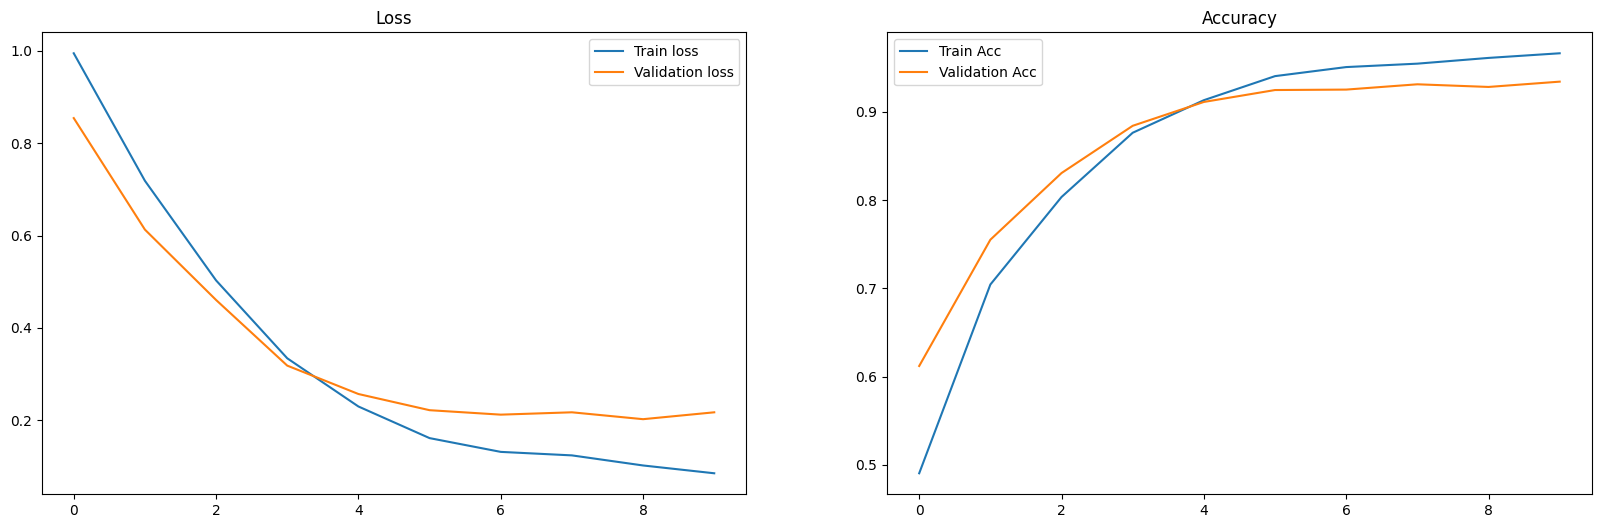

In [20]:
fig = plt.figure(figsize = (20, 6))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train loss')
plt.plot(val_losses, label='Validation loss')
plt.title("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Acc')
plt.plot(val_accs, label='Validation Acc')
plt.title("Accuracy")
plt.legend()

plt.show()

## 9. Load Model to `cpu`

In [21]:
# Load model configs
model = SentimentLSTM(**model_config)

# Load the model state dict
model.load_state_dict(torch.load(f"LSTM_{samples}_samples.pt", map_location=device))

# Move the model to CPU
#model = best_model
#model.train(False)
model.to('cpu')

SentimentLSTM(
  (embedding): Embedding(1001, 64)
  (lstm): LSTM(64, 256, num_layers=2, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=3, bias=True)
)

## 10. Make Prediction using Loaded Model

In [22]:
def padding_(seq, max_length):
    """Pad sequences to the same length"""
    if len(seq) >= max_length:
        return seq[:max_length]
    else:
        padded = np.zeros((seq.shape[0], max_length), dtype=int)
        padded[:, :seq.shape[1]] = seq
        return padded

def predict_text(text):
    word_seq = np.array([vocab[preprocess_string(word)] for word in text.split()
                         if preprocess_string(word) in vocab.keys()])
    word_seq = np.expand_dims(word_seq, axis=0)
    pad = torch.from_numpy(padding_(word_seq, 300))
    inputs = pad.to('cpu')  # Move inputs to CPU
    batch_size = 1
    h = model.init_hidden(batch_size)
    # Move the initial hidden state to CPU
    h = tuple([each.to('cpu') for each in h])
    # Set to evaluation mode
    with torch.inference_mode():
        output, h = model(inputs, h)
    print(output)
    print(torch.softmax(output, dim=-1))
    confidence, index = torch.max(torch.softmax(output.squeeze(), dim=-1), dim=-1)
    return confidence.item(), index.item()

In [23]:
import random

# Randomly select 5 index from dataset to predict
for _ in range(5):
    index = random.randint(0, samples)
    text = df['text'][index]
    actual_sentiment = df['label'][index]

    print("Text:")
    print(text)
    print('='*70)
    print(f'Actual sentiment: {actual_sentiment}')
    print('='*70)
    confidence, label_index = predict_text(text)
    predicted_sentiment = int_to_sentiment[label_index]

    # Color-coding output based on prediction matching actual sentiment
    if actual_sentiment == predicted_sentiment:
        color = '\033[92m'  # Green color for matching sentiment
    else:
        color = '\033[91m'  # Red color for mismatching sentiment

    print(f'Predicted sentiment: {color}{predicted_sentiment}\033[0m with a probability of {confidence * 100:.2f}%')
    print('='*70)

Text:
@IamABillings @JackPosobiec Cry louder ..I know it’s hard for you to admit democrats failed miserably.. again.. but just cope and seethe. It will make things easier for you https://t.co/6x496scmIX
Actual sentiment: positive
tensor([[-0.0192, -0.5037,  0.4752]])
tensor([[0.3072, 0.1892, 0.5036]])
Predicted sentiment: positive with a probability of 50.36%
Text:
@MullinsMomentum 🤣 perfect! Agree!
Actual sentiment: positive
tensor([[ 0.0277, -0.3068,  0.2372]])
tensor([[0.3391, 0.2427, 0.4182]])
Predicted sentiment: positive with a probability of 41.82%
Text:
@AudreLawdAMercy It really is one of those questions where you might be better off facing the perjury charge later than waffling on the "is a violent coup good?" question (this reply is not legal advice, please no one think this is legal advice).
Actual sentiment: neutral
tensor([[-0.0075, -0.4075,  0.2510]])
tensor([[0.3372, 0.2261, 0.4367]])
Predicted sentiment: positive with a probability of 43.67%
Text:
@leannightmares @itsn

In [24]:
def predict_custom_text(custom_text):
  confidence, index = predict_text(custom_text)
  predicted_sentiment = int_to_sentiment[index]
  print(f'Predicted: {predicted_sentiment} \nProbability {confidence * 100 :.2f}%')

In [25]:
# Custom Negative Text
custom_text = "I can't even begin to express my sheer frustration and utter disappointment with this product! It's an absolute disaster from start to finish. "
predict_custom_text(custom_text)

tensor([[-0.2160, -0.2946,  0.3616]])
tensor([[0.2698, 0.2494, 0.4808]])
Predicted: positive 
Probability 48.08%


In [26]:
# Custom Positive Text
custom_text = "I recently watched a movie that completely exceeded my expectations. From the captivating storyline to the stellar performances of the cast, every aspect of the film was a delight. The characters were well-developed and relatable, each with their own unique charm that drew me into their world. The dialogue was witty and engaging, keeping me entertained from start to finish. Additionally, the stunning visuals and masterful cinematography added depth and richness to the viewing experience. Overall, it was a cinematic masterpiece that left me feeling uplifted and inspired. I highly recommend this movie to anyone looking for a heartwarming and enjoyable film."
predict_custom_text(custom_text)

tensor([[ 0.1632, -0.1886,  0.3315]])
tensor([[0.3464, 0.2437, 0.4099]])
Predicted: positive 
Probability 40.99%
